In [19]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():  
    dev = torch.device("cuda:0")
else:
    dev = torch.device("cpu")
#dev = torch.device("cpu")
print(f"Using {dev}")

Using cuda:0


2906
2.0
0.0009593353340312388
E_y2  9.403944150859879e-07
E_xy  0.0020317306204080702
E_x2  4.666666666666667
[0.0007685758196810749, 0.0010016745056947891, 0.0011077556767178525]
m  0.00016958992851838877
0.0006201554769944613
MAX LENGTH:68


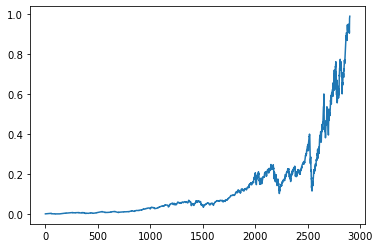

0
[[3.016000659743296e-05, 0.8235294117647058], [-1.7698469404437736e-05, 0.5588235294117647], [9.314400680024087e-07, 0.6323529411764706]]
output: [4.404512901318457e-05]
2
[[-1.7698469404437736e-05, 0.5588235294117647], [9.314400680024087e-07, 0.6323529411764706], [4.404512901318457e-05, 0.8382352941176471]]
output: [3.1393545377904624e-05]
4
[[9.314400680024087e-07, 0.6323529411764706], [4.404512901318457e-05, 0.8382352941176471], [3.1393545377904624e-05, 1.0]]
output: [-5.425475284251654e-06]
6
[[4.404512901318457e-05, 0.8382352941176471], [3.1393545377904624e-05, 1.0], [-5.425475284251654e-06, 0.35294117647058826]]
output: [1.2586161925481529e-05]
8
[[3.1393545377904624e-05, 1.0], [-5.425475284251654e-06, 0.35294117647058826], [1.2586161925481529e-05, 0.5147058823529411]]
output: [-2.1443869167416413e-05]
10
[[-5.425475284251654e-06, 0.35294117647058826], [1.2586161925481529e-05, 0.5147058823529411], [-2.1443869167416413e-05, 0.39705882352941174]]
output: [-2.1870233914443498e-05]

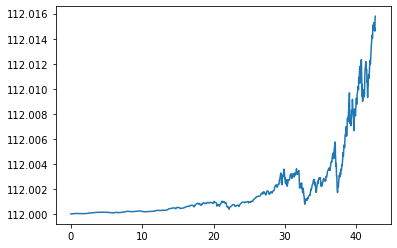

In [20]:
# ---- data loading and pre-processing ---- #

import utils.polar_pla as pla
import numpy as np
import torch
from torch.autograd import Variable

torch.set_default_tensor_type('torch.cuda.FloatTensor')
# read in time series into temporary list
temp = []
f = open('DataSets/CTtemp.csv', 'r')
for line in f.readlines():
    temp.append(float(line))

# run bottom up piecewise linear approximation on that list and store processed values
temp = pla.median_filter(temp, 5)
data, max_len = pla.sliding_window_pla(temp, 0.00001)#pla.sliding_window_pla(temp,0.001)
pla.display_trends(data, 112)
#print(data)
# set the sequence length (the number of trends we look at to predict the next) and the train to test ratio
seq_length = 3
train_proportion = 0.8

# segment the data into input output pairs that we will use to train the model
def sliding_window(data):
    inputs = []
    outputs = []
    for i in range(0, len(data)-seq_length*2, 2):
        print(i)
        temp = data[i:(i+seq_length*2)]
        new = []
        for x in range(0,len(temp),2):
            new.append([temp[x],temp[x+1]])
        #print(new)
        inputs.append(new)
        print(new)
        print("output: "+str(data[i+seq_length*2:i+seq_length*2+1]))
        #inputs.append(data[i:(i+seq_length*2)]) # the next n are the input
        #inputs.append([temp[::2],temp[1::2]])
        outputs.append(data[i+seq_length*2:i+seq_length*2+1]) # and the one after that is the output
    return Variable(torch.cuda.FloatTensor(np.array(inputs)).to(dev)), Variable(torch.cuda.FloatTensor(np.array(outputs)).to(dev))
# convert data to tensor, and apply dataloader
total_data_input, total_data_output = sliding_window(data)
train_size = int(len(total_data_input)*train_proportion)

training_data_input = torch.narrow(total_data_input, 0, 0, train_size).to(dev)
training_data_output = torch.narrow(total_data_output, 0, 0, train_size).to(dev)

testing_data_input = torch.narrow(total_data_input, 0, train_size, len(total_data_input) - train_size).to(dev)
testing_data_output = torch.narrow(total_data_output, 0, train_size, len(total_data_input) - train_size).to(dev)

train = torch.utils.data.TensorDataset(training_data_input, training_data_output)
test = torch.utils.data.TensorDataset(testing_data_input, testing_data_output)
trainset = torch.utils.data.DataLoader(train, batch_size=320, shuffle=False)
testset = torch.utils.data.DataLoader(test, batch_size=320, shuffle=False)

In [21]:
from models import TCN

#net = TCN(seq_length,2,[2,64,64])#TCN(seq_length*2, 1, [2]*32)
net = TCN(seq_length,1, [128]*2, 2, 0.1)
net = net.to(dev)
print(net)

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(3, 128, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.1, inplace=False)
        (conv2): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.1, inplace=False)
        (net): Sequential(
          (0): Conv1d(3, 128, kernel_size=(2,), stride=(1,), padding=(1,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
          (4): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.1, inplace=False)
        )
        (downsample): Conv1d(3, 128, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(128, 128, kernel_size=(2,), stride

Epoch: 0/2000, loss: 0.06834566593170166
Epoch: 200/2000, loss: 6.511003448395059e-05
Epoch: 400/2000, loss: 6.156769813969731e-05
Epoch: 600/2000, loss: 6.164841033751145e-05
Epoch: 800/2000, loss: 6.203252996783704e-05
Epoch: 1000/2000, loss: 6.492658576462418e-05
Epoch: 1200/2000, loss: 6.511947140097618e-05
Epoch: 1400/2000, loss: 6.298864173004404e-05
Epoch: 1600/2000, loss: 6.636814214289188e-05
Epoch: 1800/2000, loss: 6.364445289364085e-05
Epoch: 2000/2000, loss: 6.321898399619386e-05


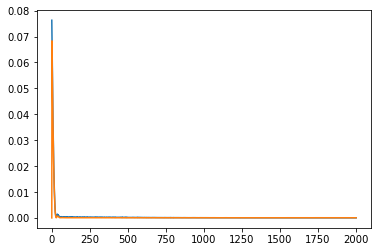

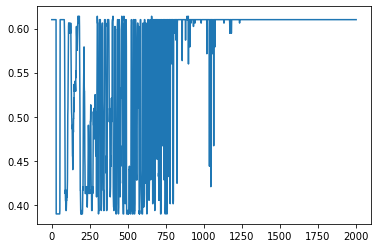

Lowest validation loss: 6.142578058643267e-05 at epoch 1234


In [22]:
# training

epochs = 2000

import torch.optim as optim
train_loss = []
validation_loss = []
net.train()
epoch_total_trainloss = 0 # the total loss for each epoch, used for plotting
min_val_loss_epoch = 0 # the epoch with the lowest validation loss
min_val_loss = 1000000 # the lowest validation loss
optimizer = optim.Adam(net.parameters(), lr=0.0001)
train_direction_accuracy = []
validation_direction_accuracy = []
for epoch in range(epochs+1):

    validation_loss.append(epoch_total_trainloss) # we'll need to plot validation loss too
    epoch_total_trainloss = 0 # reset this for the validation epoch'''
    net.train()
    for data in trainset:  # for each batch
        features, labels = data  # split the batches up into their features and labels
        net.zero_grad()
        output = net(features)  # get a prediction from the model
        output = output
        #print(output.shape)
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        loss.backward()  # backpropogate the loss
        optimizer.step()  # optimize weights
        epoch_total_trainloss += loss.item()/len(trainset)  # sum the losses of this epoch
        torch.cuda.synchronize()
    
    train_loss.append(epoch_total_trainloss) # add this epoch's loss in order to plot it later
    epoch_total_trainloss = 0 # reset this for the validation epoch

    # now we'll calculate the direction accuracy for the training and validation sets
    correct=0
    net.eval()
    for data in testset:
        
        inputs, labels = data
        output = net(inputs)
        for i in range(len(output)):
            pred = output[i]
            actual = labels[i]
            if pred < 0 and actual < 0 or pred > 0 and actual > 0:
                correct += 1
            #print(output[0],labels[0])
        loss = F.mse_loss(output, labels)  # calculate the loss of our prediction
        epoch_total_trainloss += loss.item()/len(testset)
        torch.cuda.synchronize()
    
    if epoch_total_trainloss < min_val_loss:
        min_val_loss = epoch_total_trainloss
        min_val_loss_epoch = epoch
    validation_direction_accuracy.append(correct/len(test))

    if epoch %(epochs/10) == 0: print(f"Epoch: {epoch}/{epochs}, loss: {loss.item()}")

import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
plt.plot(validation_direction_accuracy)
plt.show()
print(f"Lowest validation loss: {min_val_loss} at epoch {min_val_loss_epoch}")

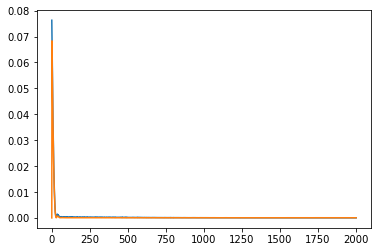

Directional Accuracy: 61.003861003861005


In [24]:
# test
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(validation_loss)
plt.show()
net.eval()
correct=0
output_file = open("utils/angles.txt", "w")
for data in trainset:

    inputs, labels = data
    output = net(inputs)
    for i in range(len(output)):
        pred = output[i]
        output_file.write(str(pred.item()*90)+"\n")

for data in testset:
    inputs, labels = data
    output = net(inputs)
    for i in range(len(output)):
        pred = output[i]
        actual = labels[i]
        if pred < 0 and actual < 0 or pred > 0 and actual > 0:
            correct += 1
        output_file.write(str(pred.item()*90)+"\n")
print(f'Directional Accuracy: {correct*100/len(test)}')